# R - Clustering Analysis

The dataset : https://www.kaggle.com/carlolepelaars/toy-dataset

Content :

Note: All data is fictional. The data has been generated so that their distributions are convenient for statistical analysis.

* Number: A simple index number for each row
* City: The location of a person (Dallas, New York City, Los Angeles, Mountain View, Boston, Washington D.C., San Diego and Austin)
* Gender: Gender of a person (Male or Female)
* Age: The age of a person (Ranging from 25 to 65 years)
* Income: Annual income of a person (Ranging from -674 to 177175)
* Illness: Is the person Ill? (Yes or No)

## Dataset Analysis And preprocessing

### Imports

In [1]:
library(namespace)
registerNamespace('psy', loadNamespace('psych'))
library(ggplot2)
library(reshape2)
library("IRdisplay")
library(ade4)
library(factoextra)
library(NbClust)
library(bootcluster)

<environment: namespace:psych>

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'ade4' was built under R version 3.6.3"Warning message:
"package 'factoextra' was built under R version 3.6.3"Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


In [2]:
csv <- read.csv("data/toy_dataset.csv", header = TRUE)
head(csv[,2:ncol(csv)])

City,Gender,Age,Income,Illness
Dallas,Male,41,40367,No
Dallas,Male,54,45084,No
Dallas,Male,42,52483,No
Dallas,Male,40,40941,No
Dallas,Male,46,50289,No
Dallas,Female,36,50786,No


### Data Understanding

#### Univariate Analysis

In [3]:
df <- as.data.frame(table(csv[,2]))
df[order(df$Freq),]

,Var1,Freq
7,San Diego,4881
8,Washington D.C.,8120
2,Boston,8301
1,Austin,12292
5,Mountain View,14219
3,Dallas,19707
4,Los Angeles,32173
6,New York City,50307


We can see that the cities are unequally proportionnate in this dataset, and this could lead to bias in our models.

In [4]:
df <- as.data.frame(table(csv[,3]))
df[order(df$Freq),]

Var1,Freq
Female,66200
Male,83800


Women are less present in this dataset than men, we should take it in account too

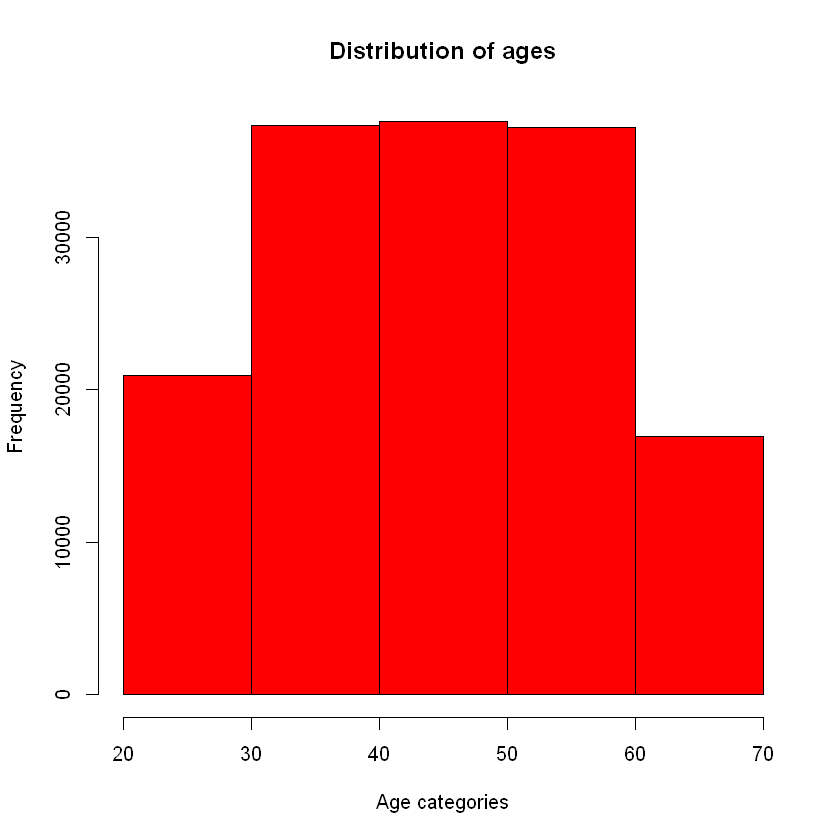

In [5]:
hist(csv[,4], breaks=pretty(csv[,4],5), col="red", xlab="Age categories", main="Distribution of ages")

Same conclusion as before, we can see that the ages follows a normal distribution, centered around 45 years old. Then, old (over 60 years old) and young (below 20 years old) people are less represented.

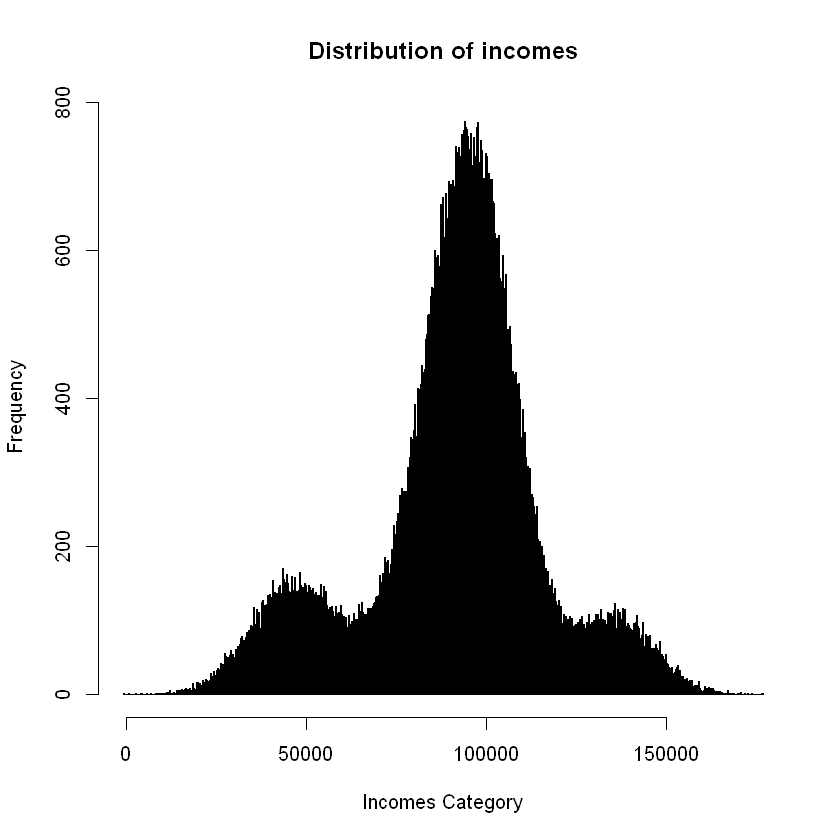

In [6]:
hist(csv[,5], breaks=pretty(csv[,5],1000), col="red", xlab="Incomes Category", main="Distribution of incomes")

Here is a relatively more complex distribution with a high peak around 95000 units per year, and with some less high peaks  : fortunate people around 130000 units per year, and less fortunate people around 50000 units per year.

In [7]:
df <- as.data.frame(table(csv[,6]))
df[order(df$Freq),]

,Var1,Freq
2,Yes,12139
1,No,137861


Lastly, we can see that our dataset contains less than a 10% ratio on Ill and Safe people.

#### Bivariate Analysis

For the simplicity of this analysis, we will only try to evaluate the combination of each row with Illness.

In [8]:
df <- as.data.frame(table(csv[,c(2,6)]))
df[order(df$City),]

,City,Illness,Freq
1,Austin,No,11281
9,Austin,Yes,1011
2,Boston,No,7615
10,Boston,Yes,686
3,Dallas,No,18094
11,Dallas,Yes,1613
4,Los Angeles,No,29605
12,Los Angeles,Yes,2568
5,Mountain View,No,13041
13,Mountain View,Yes,1178


In [9]:
prop <- c()
rows = nrow(df)/2
for(i in 1:rows){
    prop <- c(prop, df$Freq[i+rows]/df$Freq[i])
}
prop <- as.data.frame(list("City"=df$City, "Proportion"=prop))

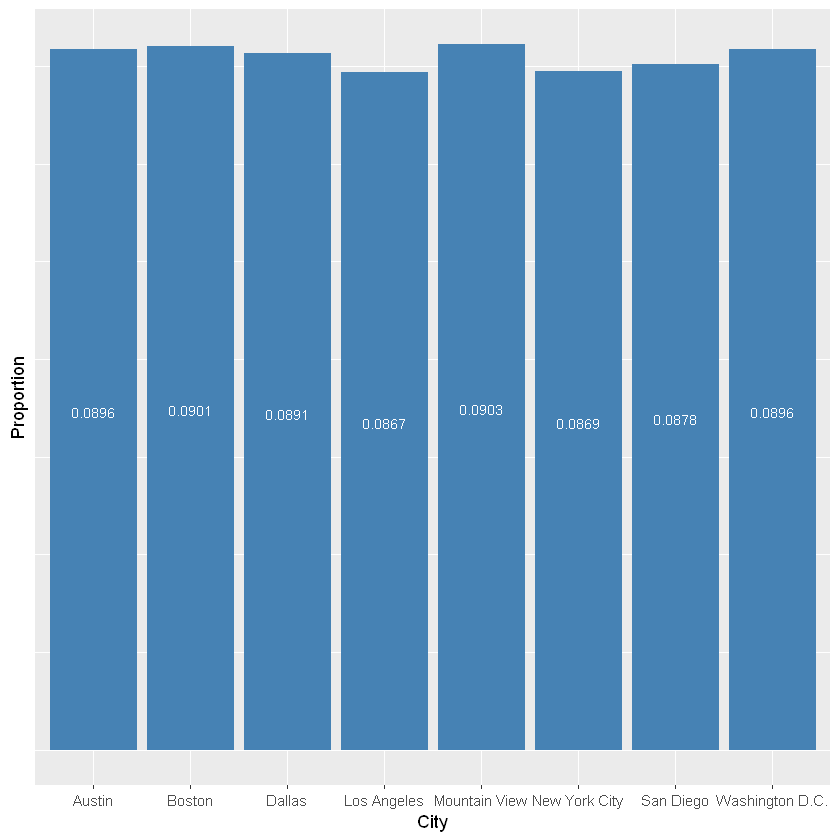

In [10]:
ggplot(data=prop, aes(x=City, y=Proportion)) +
  geom_bar(stat="identity", fill="steelblue") +
  geom_text(aes(label=round(Proportion,4)), vjust=1.6, color="white", size=3) +
  theme(axis.text.y=element_blank(),
        axis.ticks.y=element_blank())

As we can see, each city as quite the same amount of ill person, it means that it is not a deterministic factor : there are no real correlation between those columns.

In [11]:
df <- as.data.frame(table(csv[,c(3,6)]))
df[order(df$Gender),]

,Gender,Illness,Freq
1,Female,No,60869
3,Female,Yes,5331
2,Male,No,76992
4,Male,Yes,6808


In [12]:
prop <- c()
rows = nrow(df)/2
for(i in 1:rows){
    prop <- c(prop, df$Freq[i+rows]/df$Freq[i])
}
prop <- as.data.frame(list("Gender"=df$Gender, "Proportion"=prop))

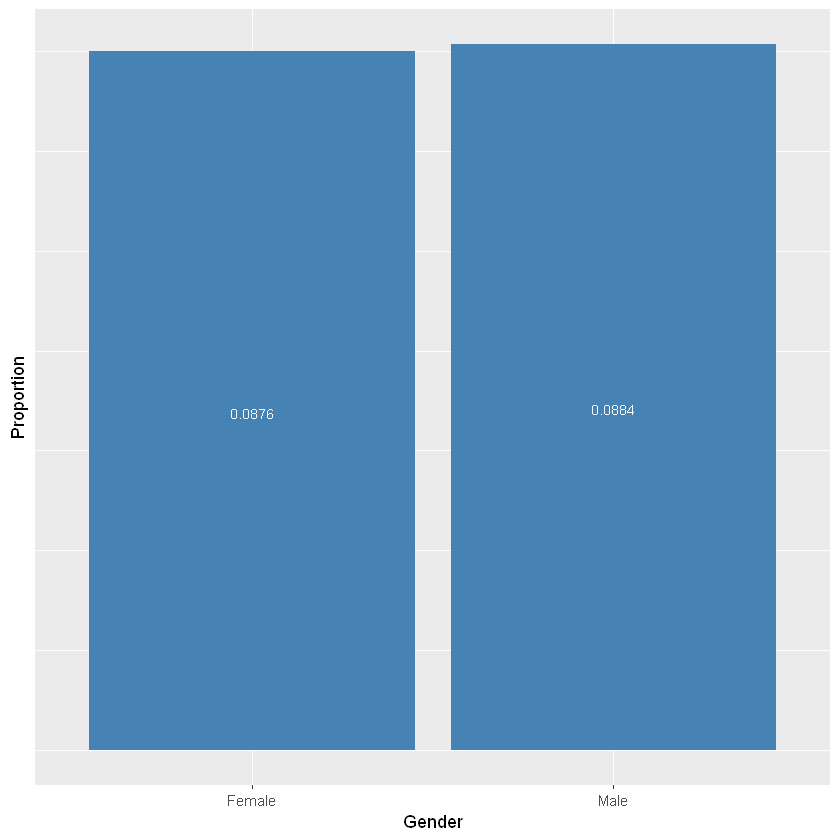

In [13]:
ggplot(data=prop, aes(x=Gender, y=Proportion)) +
  geom_bar(stat="identity", fill="steelblue") +
  geom_text(aes(label=round(Proportion,4)), vjust=1.6, color="white", size=3) +
  theme(axis.text.y=element_blank(),
        axis.ticks.y=element_blank())

Same conclusion for the gender, both have the same ratio.

---

Let's now have a look at ages by creating categories.

In [14]:
age_categories = list("Ages"=list("Min"=c(20,30,40,50,60), "Max"=c(29,39,49,59,150)), "Ill"=c(), "Safe"=c())
for(i in 1:length(age_categories$Ages$Min)){
    age_categories$Ill <- c(age_categories$Ill,0)
    age_categories$Safe <- c(age_categories$Safe,0)
}
for(i in 1:nrow(csv)){
    for(j in 1:length(age_categories$Ages$Min)){
        if(csv$Age[i] <= age_categories$Ages$Max[j] && csv$Age[i] >= age_categories$Ages$Min[j]){
            if(csv$Illness[i] == "No"){
                age_categories$Safe[j] = age_categories$Safe[j] + 1
            }else{
                age_categories$Ill[j] = age_categories$Ill[j] + 1
            }
        }
    }
}
prop <- list("Age"=c(), "Proportion"=c())
for(i in 1:length(age_categories$Ages$Min)){
    prop$Age <- c(prop$Age, paste0(age_categories$Ages$Min[i],"-",age_categories$Ages$Max[i]))
    prop$Proportion <- c(prop$Proportion, age_categories$Ill[i]/age_categories$Safe[i])
}
prop <- as.data.frame(prop)

In [15]:
prop

Age,Proportion
20-29,0.08796707
30-39,0.08626458
40-49,0.08928675
50-59,0.08741544
60-150,0.09028147


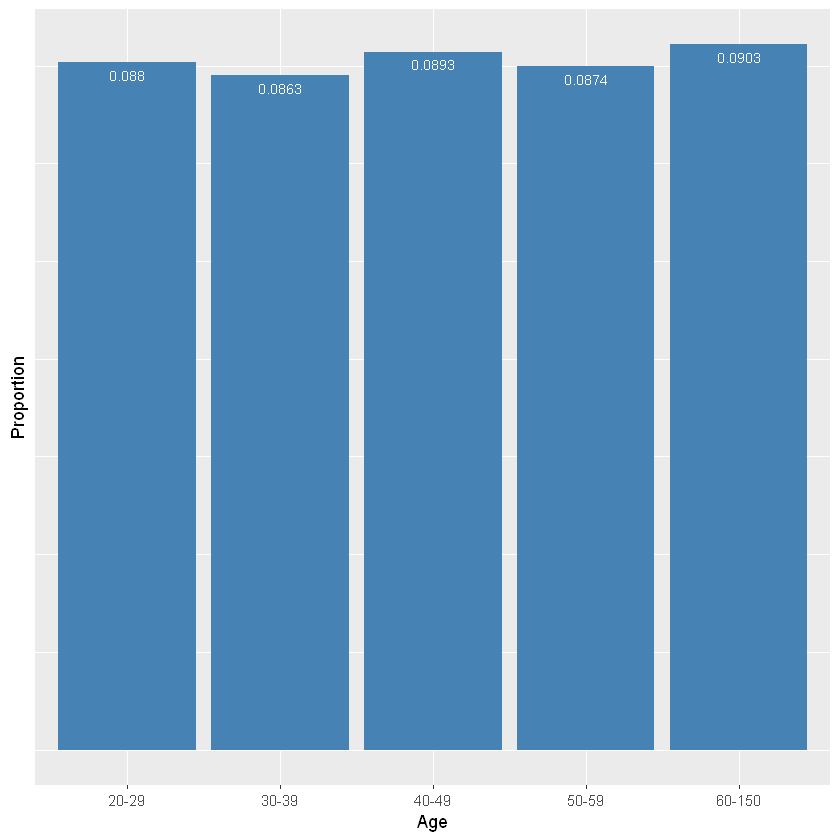

In [16]:
ggplot(data=prop, aes(x=Age, y=Proportion)) +
  geom_bar(stat="identity", fill="steelblue") +
  geom_text(aes(label=round(Proportion,4)), vjust=1.6, color="white", size=3) +
  theme(axis.text.y=element_blank(),
        axis.ticks.y=element_blank())

We can see that the ratio is quite the same for each category of age (which is a bit strange considering reality). It is probably due to the fact that those datas are not real and were uniformly generated.

In [17]:
income_categories = list("Incomes"=list("Min"=c(0,60001,125001), "Max"=c(60000,125000,200000)), "Ill"=c(), "Safe"=c())
for(i in 1:length(income_categories$Incomes$Min)){
    income_categories$Ill <- c(income_categories$Ill,0)
    income_categories$Safe <- c(income_categories$Safe,0)
}
for(i in 1:nrow(csv)){
    for(j in 1:length(income_categories$Incomes$Min)){
        if(csv$Income[i] <= income_categories$Incomes$Max[j] && csv$Income[i] >= income_categories$Incomes$Min[j]){
            if(csv$Illness[i] == "No"){
                income_categories$Safe[j] = income_categories$Safe[j] + 1
            }else{
                income_categories$Ill[j] = income_categories$Ill[j] + 1
            }
        }
    }
}
prop <- list("Incomes"=c(), "Proportion"=c())
for(i in 1:length(income_categories$Incomes$Min)){
    prop$Incomes <- c(prop$Incomes, paste0(income_categories$Incomes$Min[i],"-",income_categories$Incomes$Max[i]))
    prop$Proportion <- c(prop$Proportion, income_categories$Ill[i]/income_categories$Safe[i])
}
prop <- as.data.frame(prop)

In [18]:
prop

Incomes,Proportion
0-60000,0.08848909
60001-125000,0.08770788
125001-2e+05,0.09067758


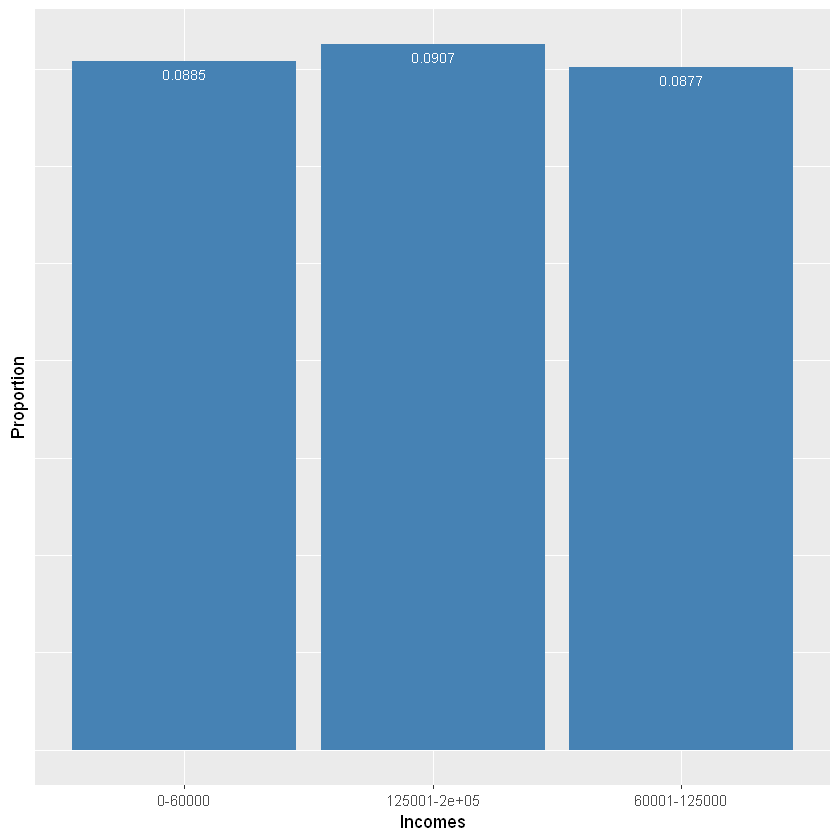

In [19]:
ggplot(data=prop, aes(x=Incomes, y=Proportion)) +
  geom_bar(stat="identity", fill="steelblue") +
  geom_text(aes(label=round(Proportion,4)), vjust=1.6, color="white", size=3) +
  theme(axis.text.y=element_blank(),
        axis.ticks.y=element_blank())

Same conclusion as before, we can't say that any column in our dataset can be linearly correlated to Illness.

### Preprocessing Data

#### Extract Binary Categorical Variable

In [20]:
df_g <- as.data.frame(table(csv[,3]))
df_i <- as.data.frame(table(csv[,6]))
rows = nrow(csv)
gender <- integer(rows)
illness <- integer(rows)
for(i in 1:rows){
    for(j in 1:nrow(df_g)){
        if(csv$Gender[i] == df_g$Var1[j]){
            gender[i] <- j-1
            break
        }
    }
    for(j in 1:nrow(df_i)){
        if(csv$Illness[i] == df_i$Var1[j]){
            illness[i] <- j-1
            break
        }
    }
}
gender_label <- df_g$Var1
illness_label <- df_i$Var1

#### Extract Multi Categorical Variable (ordinals)

In [21]:
age_categories = list("Ages"=list("Min"=c(20,30,40,50,60), "Max"=c(29,39,49,59,150)))
age <- integer(rows)
for(i in 1:nrow(csv)){
    for(j in 1:length(age_categories$Ages$Min)){
        if(csv$Age[i] <= age_categories$Ages$Max[j] && csv$Age[i] >= age_categories$Ages$Min[j]){
            age[i] <- j-1
            break
        }
    }
}
age_label <- c()
for(i in 1:length(age_categories$Ages$Min)){
    age_label <- c(age_label, paste0(age_categories$Ages$Min[i],"-",age_categories$Ages$Max[i]))
}

In [22]:
income_categories = list("Incomes"=list("Min"=c(0,60001,125001), "Max"=c(60000,125000,200000)))
income <- integer(rows)
for(i in 1:nrow(csv)){
    for(j in 1:length(income_categories$Incomes$Min)){
        if(csv$Income[i] <= income_categories$Incomes$Max[j] && csv$Income[i] >= income_categories$Incomes$Min[j]){
            income[i] <- j-1
            break
        }
    }
}
income_label <- c()
for(i in 1:length(income_categories$Incomes$Min)){
    income_label <- c(income_label, paste0(income_categories$Incomes$Min[i],"-",income_categories$Incomes$Max[i]))
}

#### Extract Multi Categorical Variable (non-ordinal)

In [23]:
df_c <- as.data.frame(table(csv[,2]))
city <- matrix(0, nrow = nrow(csv), ncol = nrow(df_c))
for(i in 1:nrow(csv)){
    for(j in 1:nrow(df_c)){
        if(csv$City[i] == df_c$Var1[j]){
            city[i,j] <- 1
            break
        }
    }
}
city_label <- df_c$Var1

#### Create processed DataFrame

In [75]:
labels <- list("City"=city_label, "Gender"=gender_label, "Age"=age_label, "Income"=income_label, "Illness"=illness_label)
df <- as.data.frame(list("City"=city, "Gender"=gender, "Age"=age, "Income"=income, "Illness"=illness))

In [76]:
df[1:6,]

City.1,City.2,City.3,City.4,City.5,City.6,City.7,City.8,Gender,Age,Income,Illness
0,0,1,0,0,0,0,0,1,2,0,0
0,0,1,0,0,0,0,0,1,3,0,0
0,0,1,0,0,0,0,0,1,2,0,0
0,0,1,0,0,0,0,0,1,2,0,0
0,0,1,0,0,0,0,0,1,2,0,0
0,0,1,0,0,0,0,0,0,1,0,0


lastly, we will reduce the size (cause of memory usage)

In [77]:
print(paste0(nrow(df), "*", ncol(df)))
df <- df[sample(nrow(df), 3000), ]
print(paste0(nrow(df), "*", ncol(df)))

[1] "150000*12"
[1] "3000*12"


## Clustering And Validation

### Principal Component Analysis

We will not speak a lot of PCA since it's not the subject, but here, we will use it to reduce the dimension space to two axis.

In [78]:
pca_df <- dudi.pca(df, center=TRUE, scale=TRUE, scannf = FALSE, nf = 2)

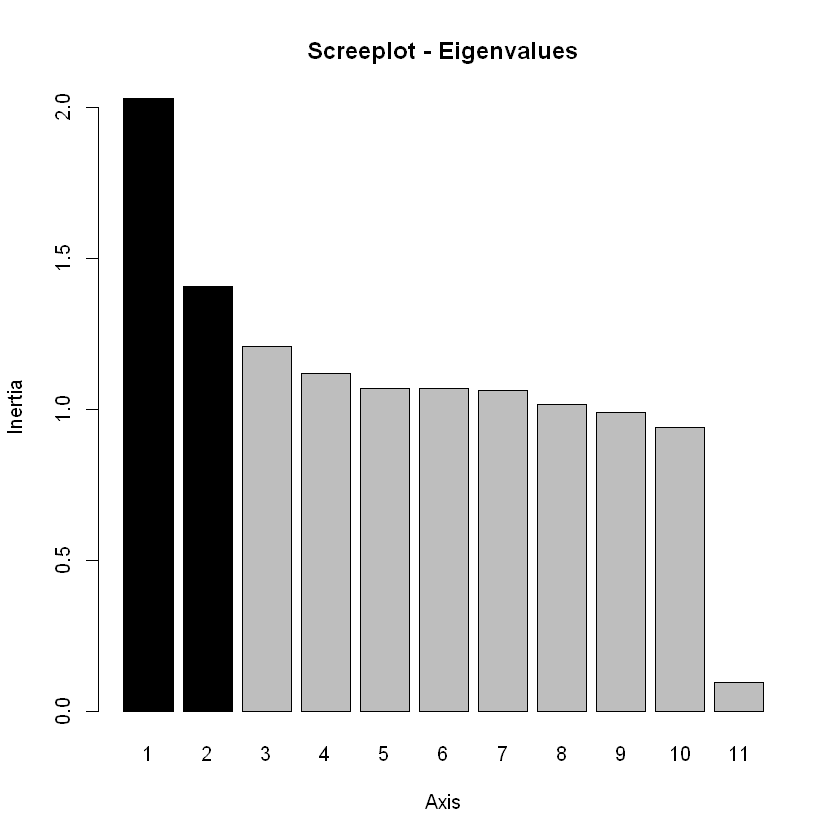

In [79]:
screeplot(pca_df, main = "Screeplot - Eigenvalues")

We clearly see that the dataset was generated since the inertia is quite constant over all the initial dimensions (excepting the last one), meaning that PCA is not as usefull as we can think. But we will still rely on the two first axis for this report.

No matter what, using the elbow method we see that two axis are still a good choice even if they only represent a small percentage of information from the inital dataset.

### Kmeans - Centroid-based Clustering

We will firstly select the best number of clusters using the Dun Index and the elbow method.

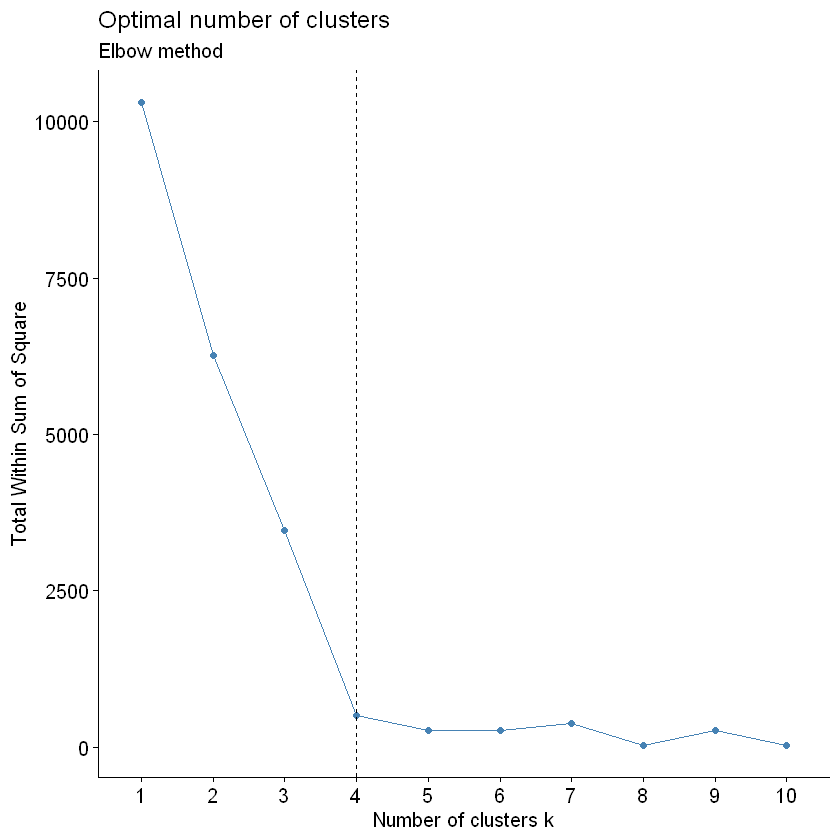

In [80]:
fviz_nbclust(pca_df$li, kmeans, method = "wss") + geom_vline(xintercept = 4, linetype = 2) + 
labs(subtitle = "Elbow method")

In [81]:
k_means = kmeans(pca_df$li,centers=4)

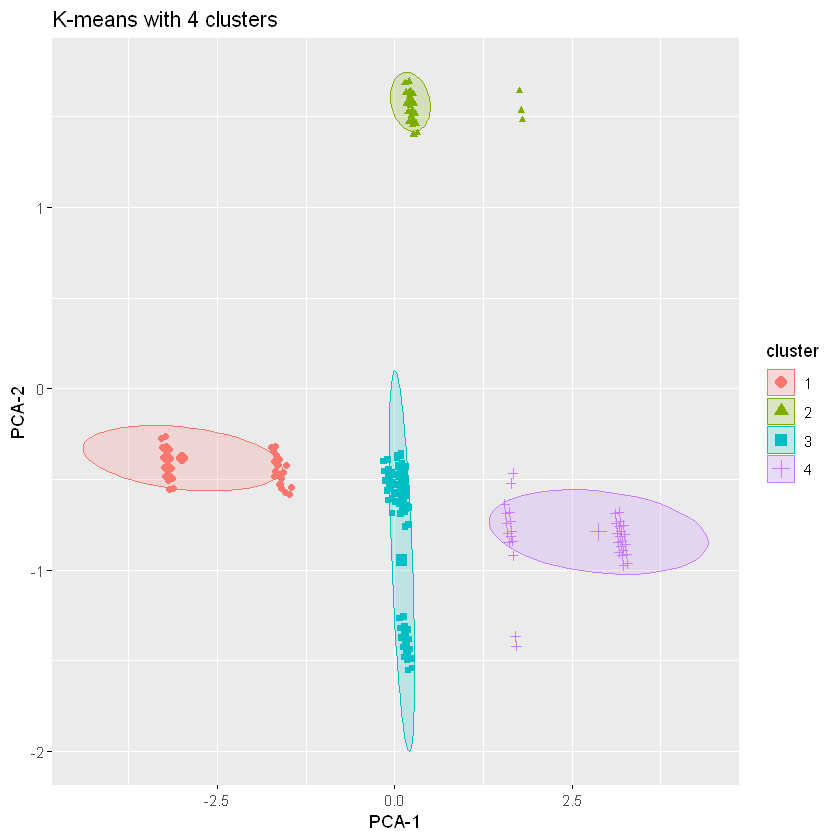

In [82]:
fviz_cluster(k_means, df, ellipse.type = "norm", geom="point") + labs(title= "K-means with 4 clusters") + 
xlab("PCA-1") + ylab("PCA-2")

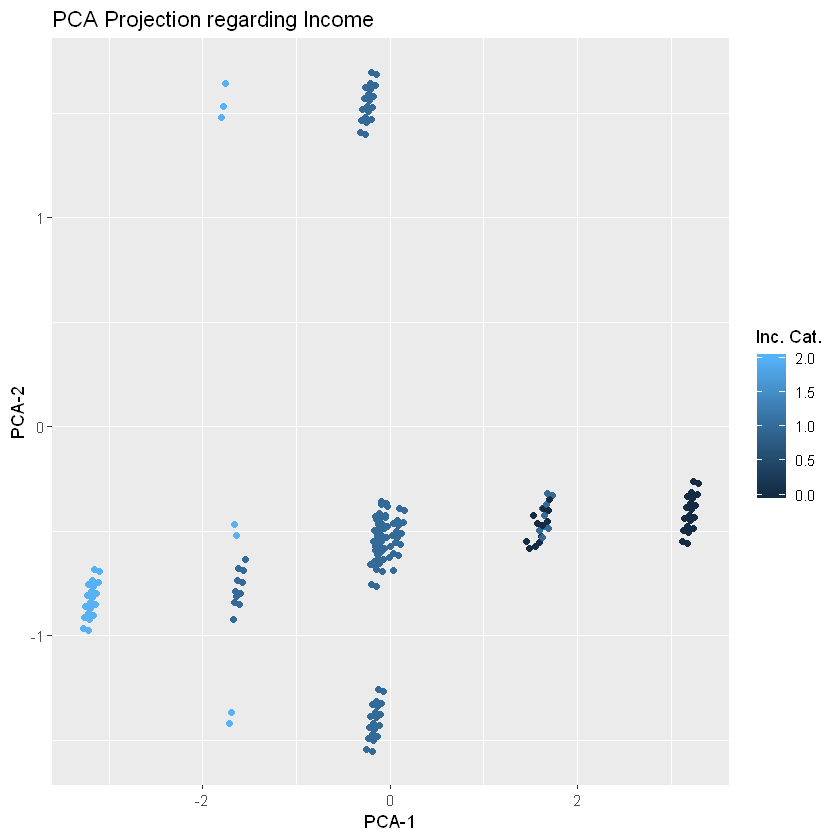

In [83]:
qplot(pca_df$li[,1], pca_df$li[,2], colour = df$Income) + 
labs(title= "PCA Projection regarding Income", color = "Inc. Cat.") + 
xlab("PCA-1") + ylab("PCA-2")

Here we clearly see that the PCA choose the categorical variable income as a major factor of information. Thus, we can see that the clustering seems to also take it in account in some ways. 

But this is not the only thing.

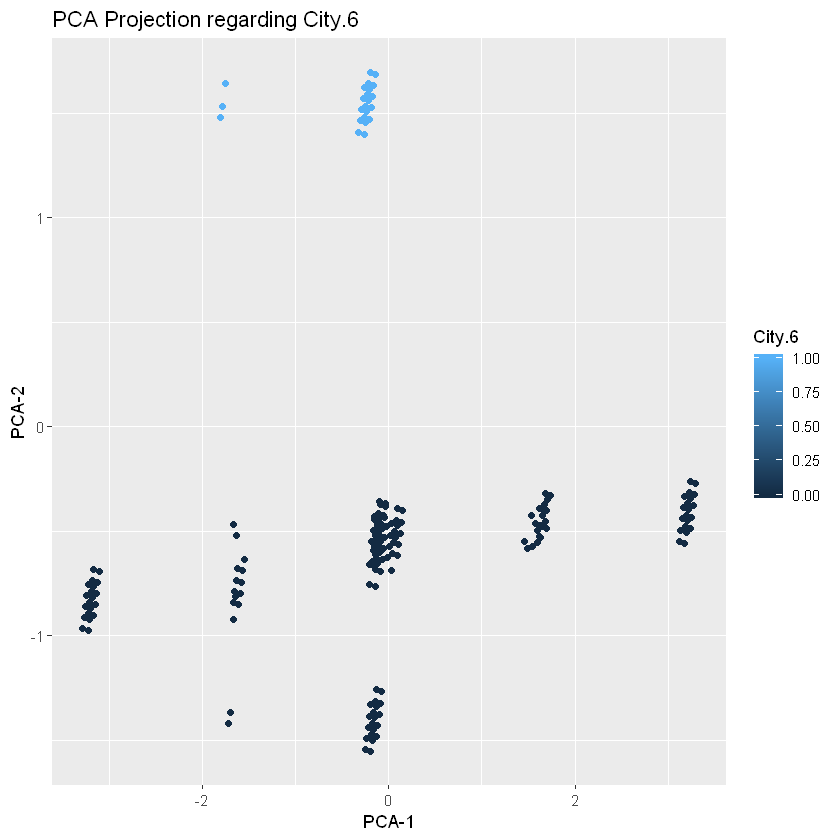

In [84]:
qplot(pca_df$li[,1], pca_df$li[,2], colour = df$City.6) + 
labs(title= "PCA Projection regarding City.6", color = "City.6") + 
xlab("PCA-1") + ylab("PCA-2")

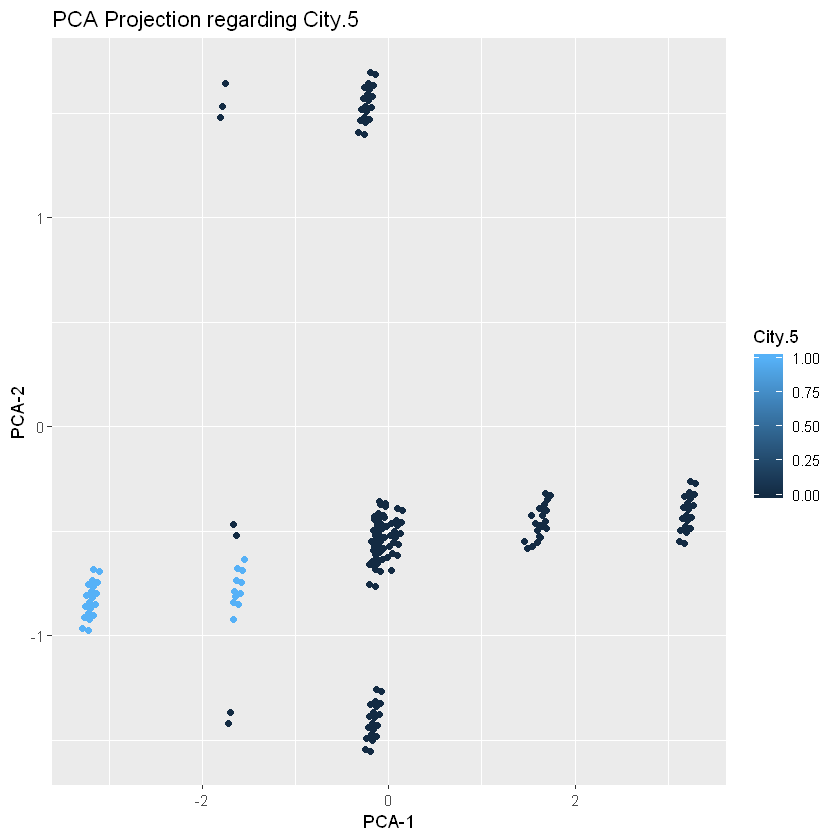

In [85]:
qplot(pca_df$li[,1], pca_df$li[,2], colour = df$City.5) + 
labs(title= "PCA Projection regarding City.5", color = "City.5") + 
xlab("PCA-1") + ylab("PCA-2")

Here we see that Cities introduce a huge bias in our PCA. The other variables are all well distributed in the clusters. So we will try to delete cities from our pca. 

Note that something is still interesting :
- As we can see in the city.6, the richer people seems to be concentrated, and the clustering seems to have understand this.


In [86]:
df <- df[,(ncol(df)-3):ncol(df)]
head(df)

,Gender,Age,Income,Illness
134058,0,2,1,0
124022,0,2,1,0
103065,0,4,2,1
124507,1,3,1,0
45404,0,2,1,0
65161,0,2,1,0


In [87]:
pca_df <- dudi.pca(df, center=TRUE, scale=TRUE, scannf = FALSE, nf = 2)

ERROR: Error in +labs(subtitle = "Elbow method"): argument incorrect pour un opérateur unitaire


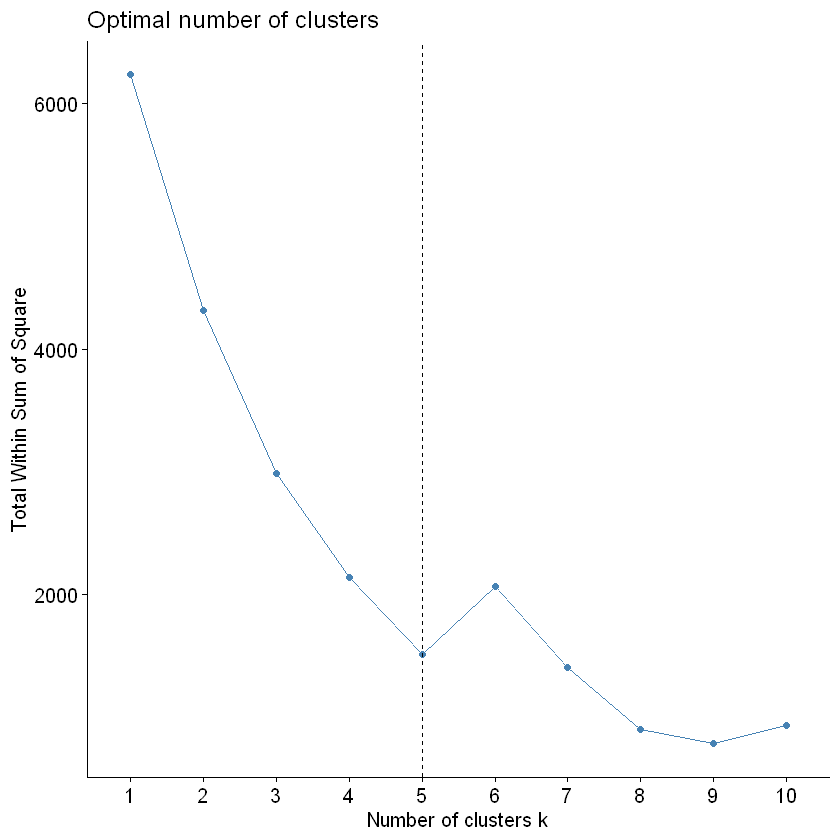

In [88]:
fviz_nbclust(pca_df$li, kmeans, method = "wss") + geom_vline(xintercept = 5, linetype = 2)
+ labs(subtitle = "Elbow method")

In [93]:
k_means = kmeans(pca_df$li,centers=5)

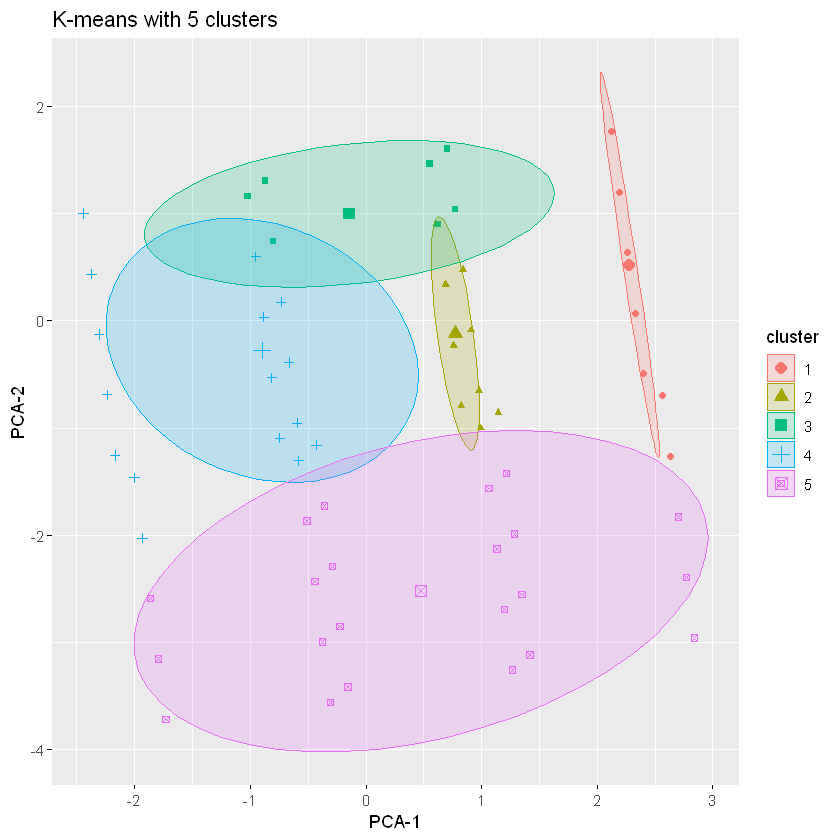

In [94]:
fviz_cluster(k_means, df, ellipse.type = "norm", geom="point") + labs(title= "K-means with 5 clusters") + 
xlab("PCA-1") + ylab("PCA-2")

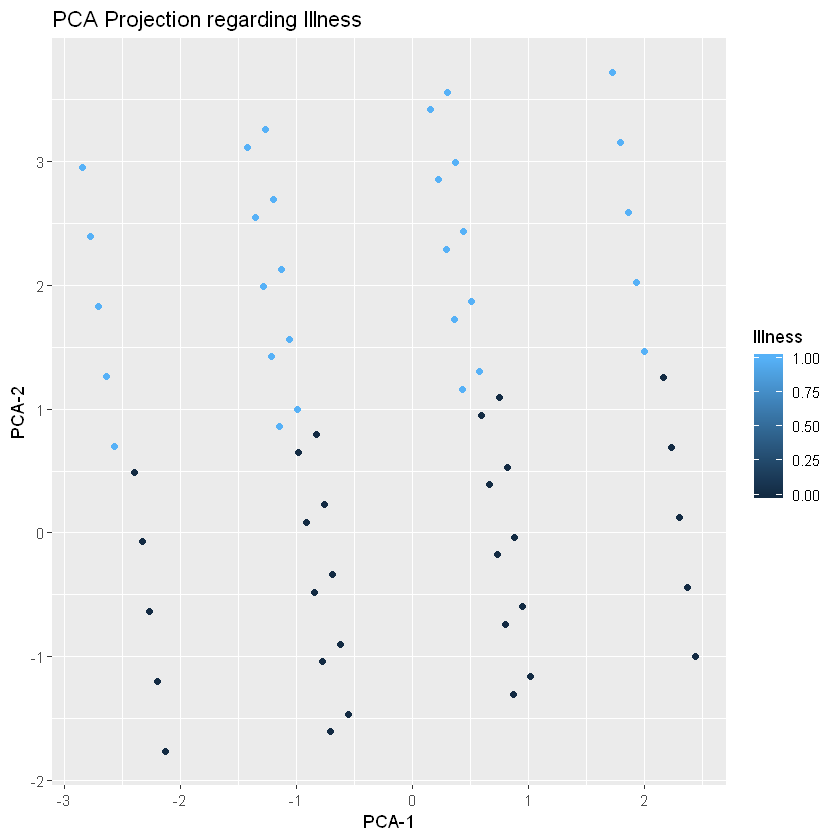

In [95]:
qplot(pca_df$li[,1], pca_df$li[,2], colour = df$Illness) + 
labs(title= "PCA Projection regarding Illness", color = "Illness") + 
xlab("PCA-1") + ylab("PCA-2")

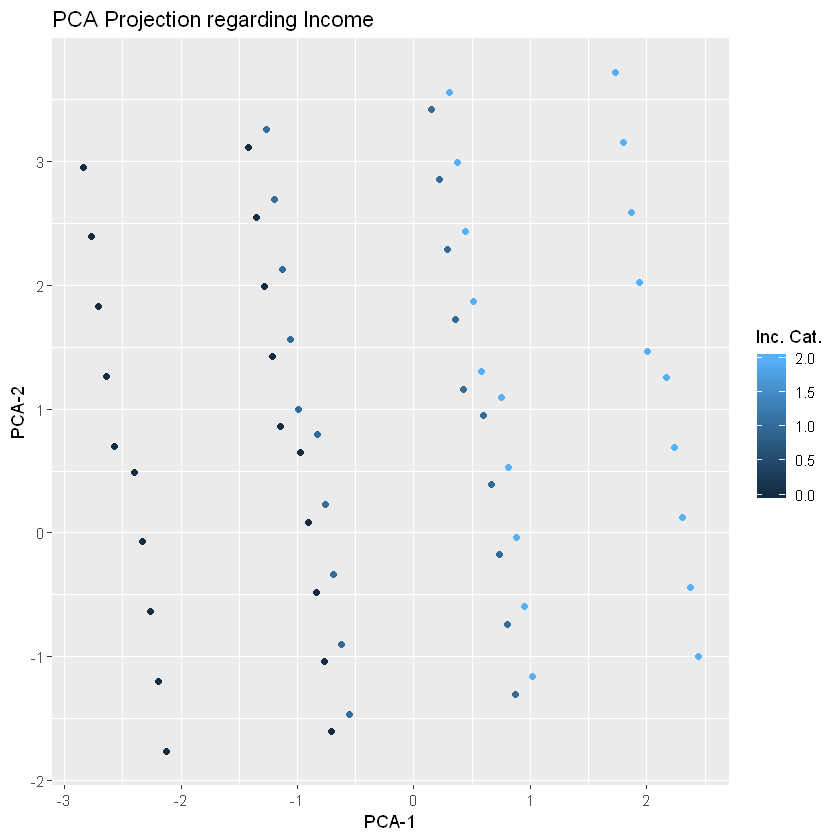

In [96]:
qplot(pca_df$li[,1], pca_df$li[,2], colour = df$Income) + 
labs(title= "PCA Projection regarding Income", color = "Inc. Cat.") + 
xlab("PCA-1") + ylab("PCA-2")

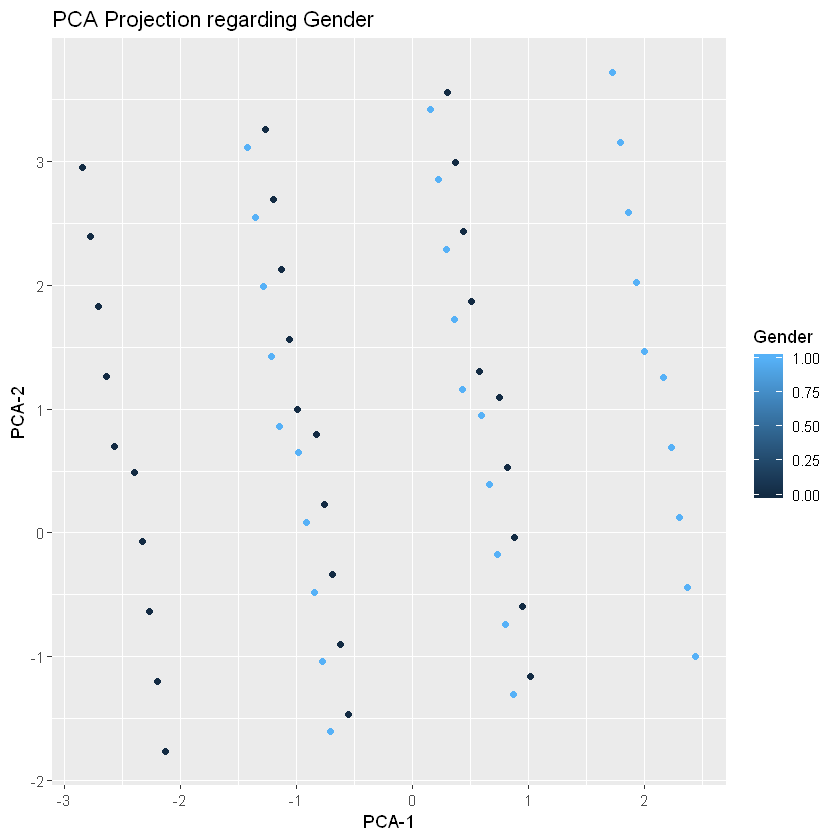

In [97]:
qplot(pca_df$li[,1], pca_df$li[,2], colour = df$Gender) + 
labs(title= "PCA Projection regarding Gender", color = "Gender") + 
xlab("PCA-1") + ylab("PCA-2")

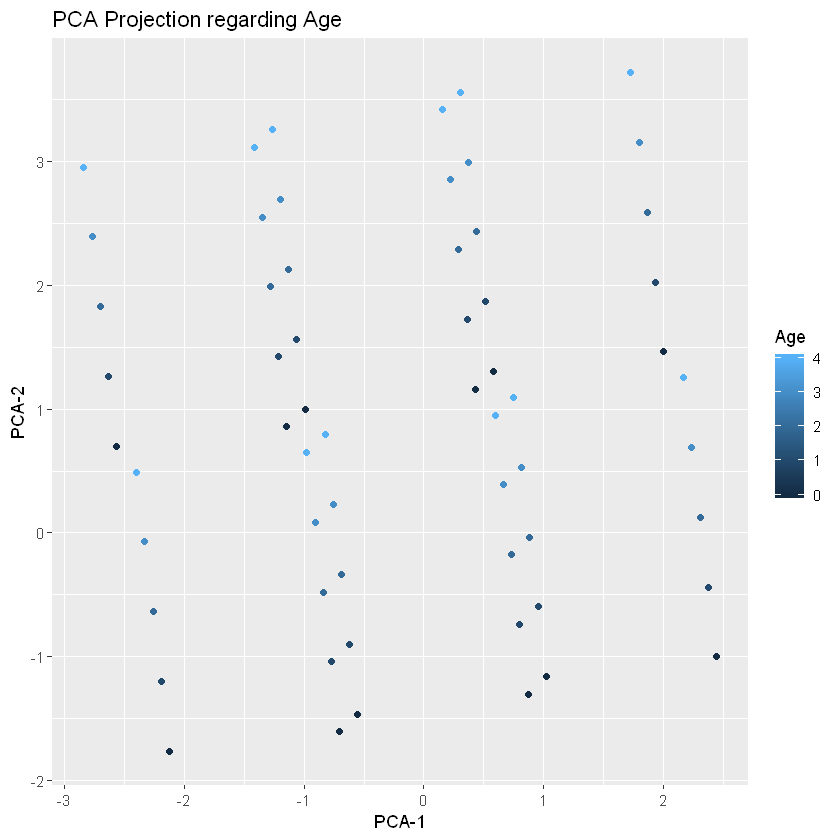

In [98]:
qplot(pca_df$li[,1], pca_df$li[,2], colour = df$Age) + 
labs(title= "PCA Projection regarding Age", color = "Age") + 
xlab("PCA-1") + ylab("PCA-2")

In this case, the clustering is not really good. But it still better than before :

* We see that the PCA decided to create to distinct cluster based on illness which in our case could be interessant.
* Data are also clustered by the income category.

We could say those basics laws regarding to the result of clustering :

* Violet Cluster => Non-ill
* The other are ill, but with different criteria based on income, age or gender

#### Bootstraping Validation

In [118]:
k.select(pca_df$li, 2:8, B = 10, r = 3, threshold = 0.6, scheme_2 = TRUE)

$profile
        2         3         4         5         6         7         8 
0.8849386 0.4895999 0.3985585 0.4054961 0.2123495 0.2530043 0.3740792 

$k
[1] 2

As we may have already find, the best k in with the pca is 2. Meaning that the best cluster would be Ill and Non-Ill.